# This notebook looks at the DOE of SOLD libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming

amino_acids = list(IUPACData.protein_letters)


import doe_utils


# For simulation, create a random parent amino acid sequence to create SOLD libraries from

In [2]:
length_of_protein = 100
parent = ''.join(np.random.choice(amino_acids, length_of_protein))
print("Parent protein:", parent) 

Parent protein: YDGMMMPKPQGGLIVTDRIKGNQRLYPGHLHAGKSARKNICPRRWDPHAPCADMCNGIFQGYWMQTPCNTMALWQVTFEIKKCPKWMCKWCFDYHIFTEM


# Need to create a matrix of postion vs letters

In [3]:
num_mutated = 5 
mutated_pos = np.sort(np.random.choice(range(length_of_protein), num_mutated))
print(mutated_pos) 

[22 23 46 47 89]


## For every poisiton to mutate choose a few amino acids to mutate to, with parent amino acid at that pos. to be most probable 

In [4]:
random_muts = [] 
num_muts = 3 
parent_prob = 0.85
mut_probs = [0.05, 0.05, 0.05] # I am keeping it simple here 
assert np.sum(mut_probs) + parent_prob == 1

mut_dict = defaultdict(dict) 
for i in mutated_pos: 
    draws = list(amino_acids) 
    draws.remove(parent[i]) 
    to_draw = np.random.choice(draws, num_muts, replace = False) 
    mut_dict[int(i)] = {parent[i]: parent_prob} 
    for k,l in enumerate(to_draw):
        mut_dict[int(i)].update({str(l): mut_probs[k]})

In [5]:
# Create mutation matrix 
sold_mat = np.zeros((len(amino_acids), length_of_protein))
for k,v in mut_dict.items(): 
    for base, prob in v.items(): 
        sold_mat[amino_acids.index(base), k] = prob


sold_mat_df = pd.DataFrame(sold_mat, index = amino_acids, columns = np.arange(length_of_protein))
sold_mat_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

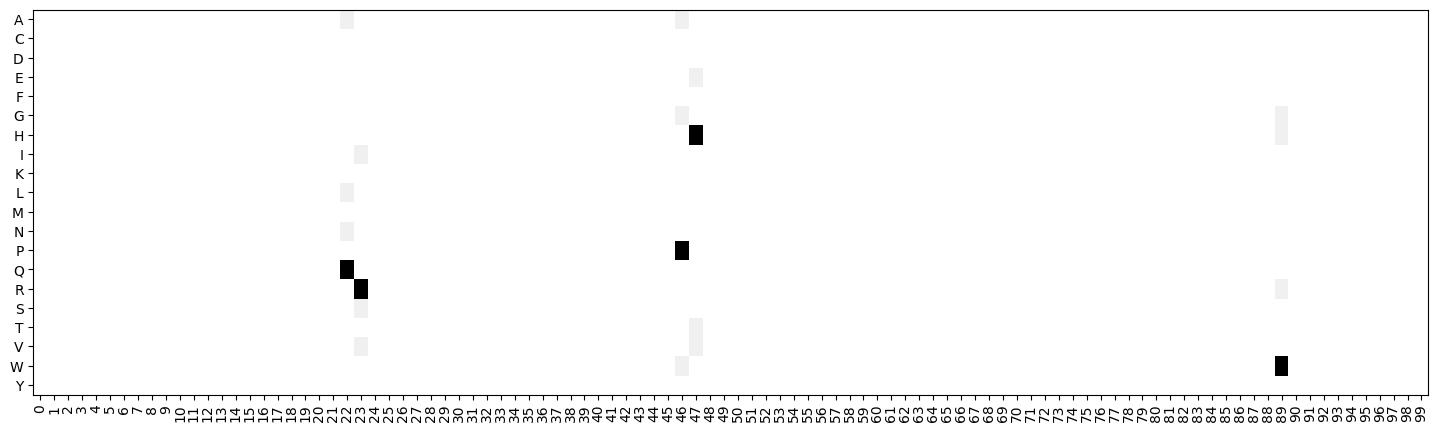

In [6]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(amino_acids)), amino_acids)


# Now let's try to draw mutated sequences from this matrix 
## Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentaliat provided SOLD mat

In [7]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)

In [8]:
a= S.compute_prob_n_mutations(num_mutated)

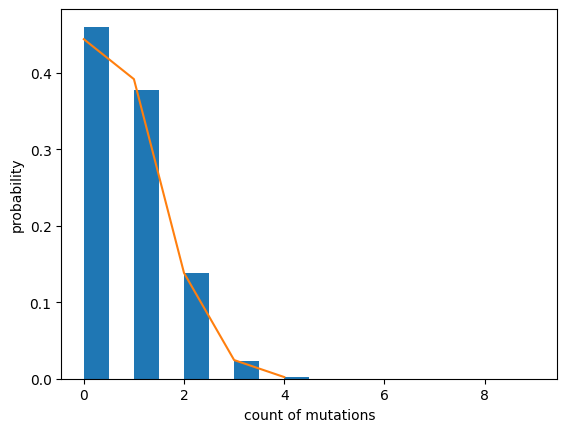

In [9]:
plt.hist(mutations, bins= np.array(range(10)), density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(a)

# Now create simulated indel activity with single muation and multi-mutation (epistatic) effects 

In [10]:
# Given a mutational landscape defined by a SOLD matric we want to create a simulator that assigns individual, 
# epistatic and effects 

In [11]:
# Run SOLD mat through the class to get the positions mutated and what muations can be observed 
S.mutation_probs

defaultdict(dict,
            {22: {'A': 0.05, 'L': 0.05, 'N': 0.05, 'Q': 0.85},
             23: {'I': 0.05, 'R': 0.85, 'S': 0.05, 'V': 0.05},
             46: {'A': 0.05, 'G': 0.05, 'P': 0.85, 'W': 0.05},
             47: {'E': 0.05, 'H': 0.85, 'T': 0.05, 'V': 0.05},
             89: {'G': 0.05, 'H': 0.05, 'R': 0.05, 'W': 0.85}})

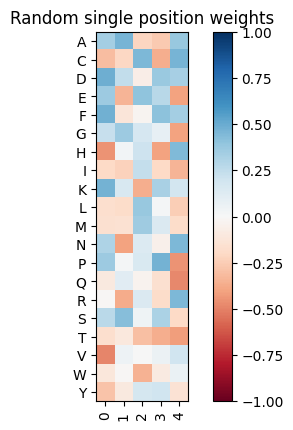

In [12]:
# assign random values (weights) to all individual, pairwise, triplet etc. 

single_weights = np.random.rand(len(amino_acids), num_mutated) - 0.5
plt.imshow(single_weights, vmin = -1, vmax = 1, cmap = 'RdBu') 
_  = plt.xticks(range(num_mutated), rotation = 90)
_  = plt.yticks(range(len(amino_acids)), amino_acids)
plt.title("Random single position weights") 
plt.colorbar() 

Text(0.5, 1.0, 'Random single position weights')

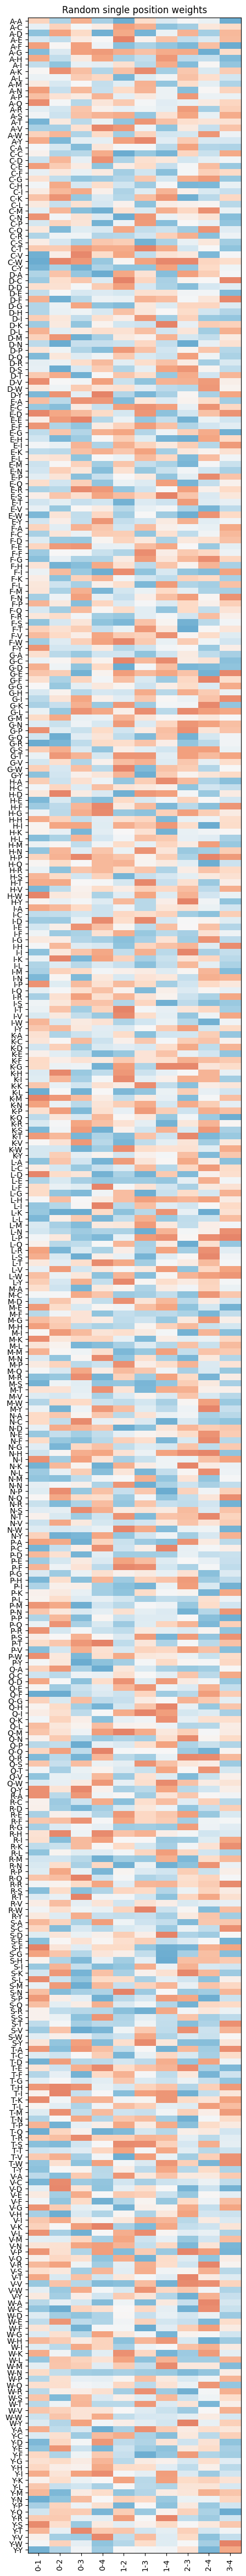

In [13]:
# pairwise mutations 
# We need to consider all possible amino acid combinations for all pariwise positions
amino_product = ['-'.join(list(x)) for x in product(amino_acids, amino_acids)]
pos_product = ['-'.join(map(str, list(x))) for x in combinations(np.arange(num_mutated), 2)]

plt.figure(figsize = (5, 60))
double_weights = np.random.rand(len(amino_product), len(pos_product)) - 0.5
plt.imshow(double_weights, vmin = -1, vmax = 1, cmap = 'RdBu', aspect = 'auto') 
_  = plt.xticks(range(len(pos_product)), pos_product, rotation = 90)
_  = plt.yticks(range(len(amino_product)), amino_product)
plt.title("Random double position weights") 
#plt.colorbar() 

In [14]:
# Now I simply need to encode every sequence in this manner 

def seq_encoder(seq): 
    """
    Encode the sequence into binary matrices of individual and pairwise codes  
    """
    